# Volatility Modeling

## I. Data Analysis and Preprocessing

### I.1. Setup & Data Ingestion
First, we load the data from BigQuery as you requested. We'll use the BatchMarketIngestor logic found in your data/ingest.py or models/batch_run.py as a reference

### Import Libraries

#### Python Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from scipy import stats
from arch import arch_model

#### Local Libraries

In [2]:
# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from data.market_data import MarketData

from src.models.lstm import lstm_fit, create_sequences_log
from src.models.arima_garch import arima_fit, garch_fit

from src.utils.clean_data import clean_data
from src.utils.invariants import check_invariants

from src.evaluation.backtest import backtest


### Setup & Parameters

In [3]:
ticker = 'NVDA'  # Change to your desired asset
# ticker = 'CLP=X'
initial_date = '2020-01-01'
end_date = '2024-12-31'

market_data_source = 'bigquery'

# Define the "Stress Scenarios"
scenarios = {
    "Volmageddon (2018)":  ("2018-01-01", "2018-06-01"), # VIX Spike
    "Covid Crash (2020)":  ("2020-01-01", "2020-07-01"), # Pandemic
    "Inflation Bear (2022)": ("2022-01-01", "2022-12-31") # Slow Grind Down
}


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Loaded 2733 rows for NVDA


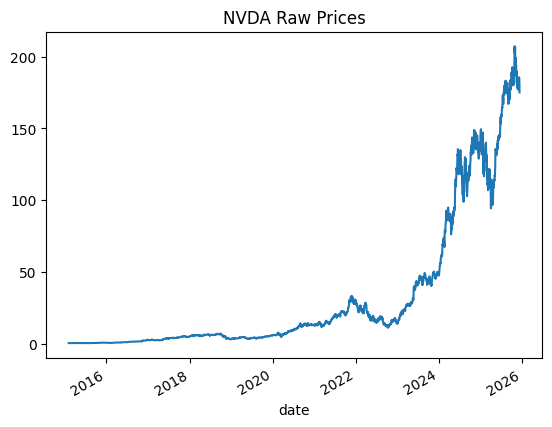

In [4]:
# Setup Project ID

if market_data_source == 'bigquery':
    PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "quant-ai-lab")
    client = bigquery.Client(project=PROJECT_ID)

    def load_data(ticker):
        """Fetches historical price data from BigQuery."""
        query = f"""
            SELECT date, price 
            FROM `{PROJECT_ID}.market_data.historical_prices`
            WHERE ticker = '{ticker}'
            ORDER BY date ASC
        """
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df
    

    # Example Usage
    df = load_data(ticker)
    print(f"Loaded {len(df)} rows for {ticker}")
    df['price'].plot(title=f"{ticker} Raw Prices")
    plt.show()

### I.2. Data Cleaning (Outlier & NaN Analysis)
Before calculating returns, we must ensure the price series is clean. We check for NaNs and unrealistic price jumps (outliers) which might be data errors.

In [5]:
df_clean = clean_data(df)

⚠️ Found 36 outliers. Smoothing...


### I.3. Calculate Invariants (Log Returns)
We calculate Log Returns, which are the candidate "Invariants" for our analysis.

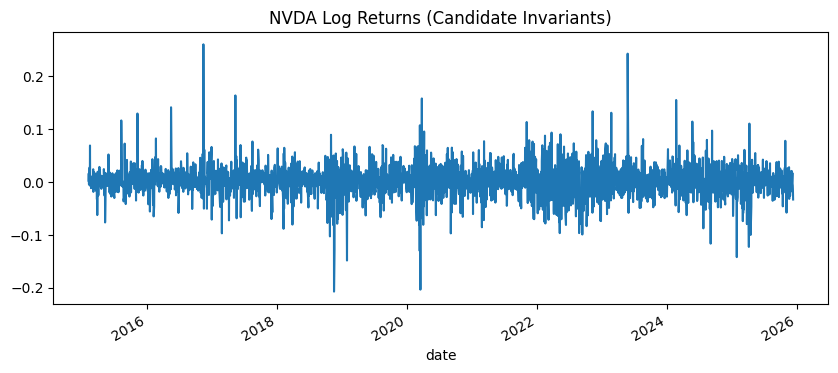

In [6]:
# Calculate Log Returns
df_clean['log_ret'] = np.log(df_clean['price'] / df_clean['price'].shift(1))
df_clean.dropna(inplace=True)

# Visualize
plt.figure(figsize=(10, 4))
df_clean['log_ret'].plot()
plt.title(f"{ticker} Log Returns (Candidate Invariants)")
plt.show()

### I.4. The Meucci "Check for Invariants"
This is the core statistical rigor step. According to Meucci, for a series to be a true invariant (i.i.d.), it must satisfy:

Independence: No autocorrelation (the past does not predict the future linearly).

Identical Distribution (Stability): The distribution properties (mean, variance) do not change over time.

We use the code structure similar to your baseline.py.

In [7]:
# Run the test
is_independent, is_stable = check_invariants(df_clean['log_ret'])

--- Meucci Invariance Check ---
1. Independence (Ljung-Box): p-value = 0.0000
   ❌ FAIL: Autocorrelation detected (Linear memory exists).
2. Stability (KS Test):      p-value = 0.0046
   ❌ FAIL: Structural break detected (Regime change/Clustering).


## II. ARIMA - GARCH Modeling
Conditional Modeling StrategyBased on the results of the Meucci test, we decide which model to apply.If Independent but Unstable: The mean is constant, but variance changes (Standard Volatility Clustering) $\to$ GARCH.If Dependent (Not Independent): There is linear memory $\to$ ARIMA.If Both Fail: We might need ARIMA-GARCH.

### II.1 ARIMA

In [8]:
modeling_series, is_stable_resid = arima_fit(df_clean, is_independent, is_stable)


>>> Detected Linear Dependence. Fitting ARIMA Model...


c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\fe_ma\miniconda3\envs\quant-ai-lab\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                 2732
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5696.680
Date:                Mon, 22 Dec 2025   AIC                         -11385.360
Time:                        18:25:21   BIC                         -11361.708
Sample:                             0   HQIC                        -11376.812
                               - 2732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.817      0.000       0.001       0.003
ar.L1         -0.5066      0.215     -2.358      0.018      -0.928      -0.085
ma.L1          0.4605      0.221      2.081      0.0

### II.2 GARCH Baseline


>>> Detected Distribution Instability (Volatility Clustering). Fitting GARCH Model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6768.80
Distribution:                  Normal   AIC:                           13545.6
Method:            Maximum Likelihood   BIC:                           13569.2
                                        No. Observations:                 2732
Date:                Mon, Dec 22 2025   Df Residuals:                     2731
Time:                        18:25:21   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------------------

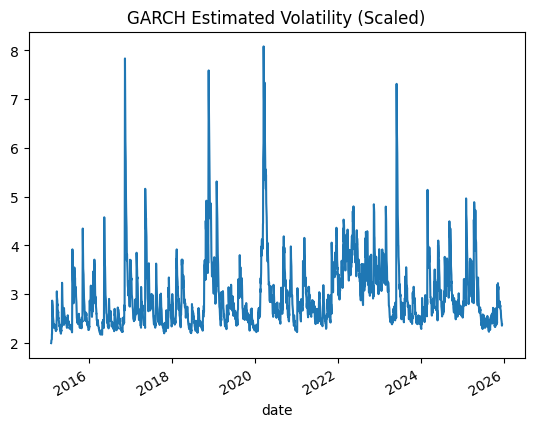

In [9]:
garch_fit(modeling_series, is_stable_resid)

## III. Deep LSTM Modeling

8. The Challenger: Deep LSTM Definition
First, we define the neural network architecture and the custom loss function directly in the notebook. This logic is adapted from your src/models/lstm.py.

9. Training & Forecasting
Now we train the model on the data.

In [10]:
# import torch

# # 1. Prepare Data
# seq_len = 66

# model, lstm_vol_annual = lstm_fit(df_clean, seq_len)

# # Align dates (LSTM loses the first SEQ_LEN days)
# lstm_dates = df_clean.index[seq_len:]
# lstm_series = pd.Series(lstm_vol_annual, index=lstm_dates, name="LSTM_Vol")

## IV. Scenario-Based Backtesting
This block iterates through major market crises. For each crisis:

It defines Train Data as everything before the crisis (the model learns "normal" behavior).

It defines Test Data as the crisis period itself (the model faces "abnormal" behavior).

It compares GARCH (fixed parameters) vs. Historical Volatility (adaptive window) vs. LTSM (adaptive window) to see which breaks first.

### IV.1 Stress Scenarios Definition


==================== SCENARIO BACKTEST RESULTS ====================

>>> Analyzing Regime: Volmageddon (2018)
    Train Size: 733 days | Test Size: 105 days
Training LSTM on cpu...
LSTM Breaches: 2 / 105
    GARCH Breach Rate:      0.95%  (Target: 1.0%)
    Historical Breach Rate: 1.90%
    LSTM Breach Rate:       1.90%


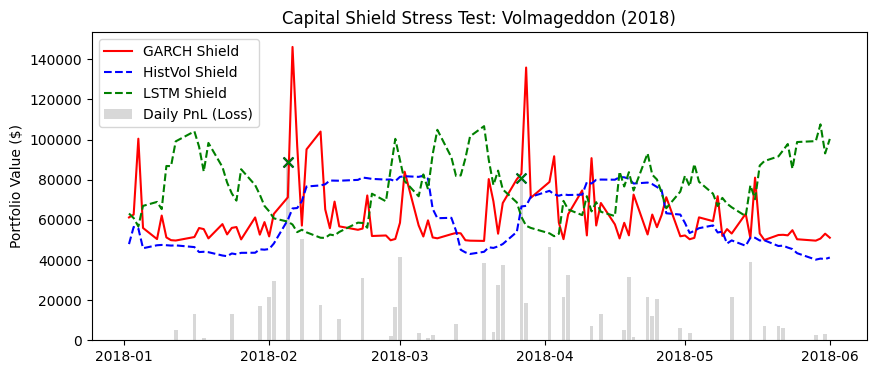


>>> Analyzing Regime: Covid Crash (2020)
    Train Size: 1236 days | Test Size: 126 days
Training LSTM on cpu...
LSTM Breaches: 6 / 126
    GARCH Breach Rate:      2.38%  (Target: 1.0%)
    Historical Breach Rate: 2.38%
    LSTM Breach Rate:       4.76%


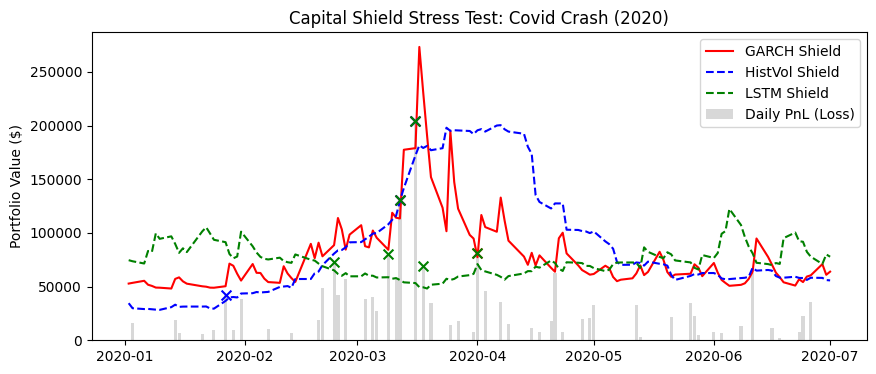


>>> Analyzing Regime: Inflation Bear (2022)
    Train Size: 1741 days | Test Size: 251 days
Training LSTM on cpu...
LSTM Breaches: 8 / 251
    GARCH Breach Rate:      2.39%  (Target: 1.0%)
    Historical Breach Rate: 0.80%
    LSTM Breach Rate:       3.19%


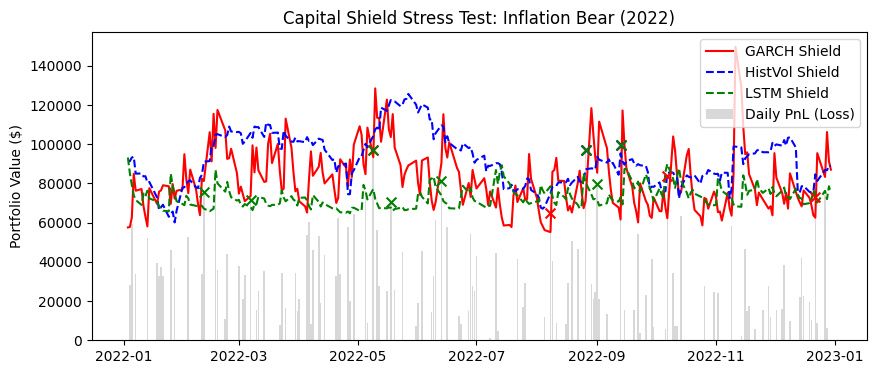

In [11]:
# Configuration for VaR
portfolio_value = 1_000_000
confidence_level = 2.33 # 99% Confidence

results = []

print(f"\n{'='*20} SCENARIO BACKTEST RESULTS {'='*20}")

for regime_name, (start_date, end_date) in scenarios.items():
    results.append(backtest(portfolio_value, confidence_level, df_clean, start_date, end_date, regime_name))
    